In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
train_df = pd.read_csv(r"D:\Samvad_Setu_final\datasets\Sign_laguage_MNSIT\sign_mnist_train\sign_mnist_train.csv")
test_df  = pd.read_csv(r"D:\Samvad_Setu_final\datasets\Sign_laguage_MNSIT\sign_mnist_test\sign_mnist_test.csv")

print(train_df.shape, test_df.shape)
train_df.head()


(27455, 785) (7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
y_train = train_df['label'].values
y_test = test_df['label'].values

X_train = train_df.drop('label', axis=1).values
X_test  = test_df.drop('label', axis=1).values


In [4]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)


In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0


In [6]:
# Labels range from 0 to 25 → total 26 categories
num_classes = 26

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)

print("One-hot encoded shapes:", y_train.shape, y_test.shape)


One-hot encoded shapes: (27455, 26) (7172, 26)


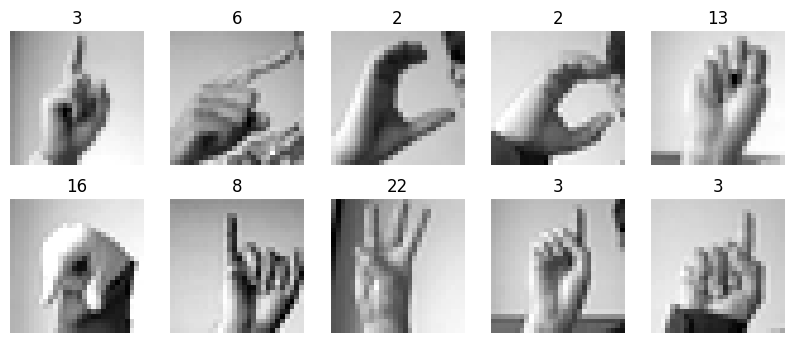

In [7]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap="gray")
    plt.title(np.argmax(y_train[i]))
    plt.axis("off")
plt.show()


In [8]:
model = Sequential([
    
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\DELL\anaconda3\envs\signlang310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 395,418 (1.51 MB)

 Trainable params: 394,970 (1.51 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)


In [11]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=64,
    epochs=30,
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - accuracy: 0.9868 - loss: 0.0464 - val_accuracy: 0.9231 - val_loss: 0.2459 - learning_rate: 0.0010
Epoch 2/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - accuracy: 0.9932 - loss: 0.0226 - val_accuracy: 0.9998 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 3/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - accuracy: 0.9948 - loss: 0.0176 - val_accuracy: 0.9809 - val_loss: 0.0609 - learning_rate: 0.0010
Epoch 4/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 36s 106ms/step - accuracy: 0.9953 - loss: 0.0139 - val_accuracy: 0.9570 - val_loss: 0.1386 - learning_rate: 0.0010
Epoch 5/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - accuracy: 0.9981 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 2.9138e-05 - learning_rate: 5.0000e-04
Epoch 6/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - accuracy: 0.9992 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 3.1260e-05 - learning_rate: 5.0000e-04
Epoch 7/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9663 - loss: 0.1290
Test Accuracy: 0.9662576913833618


225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


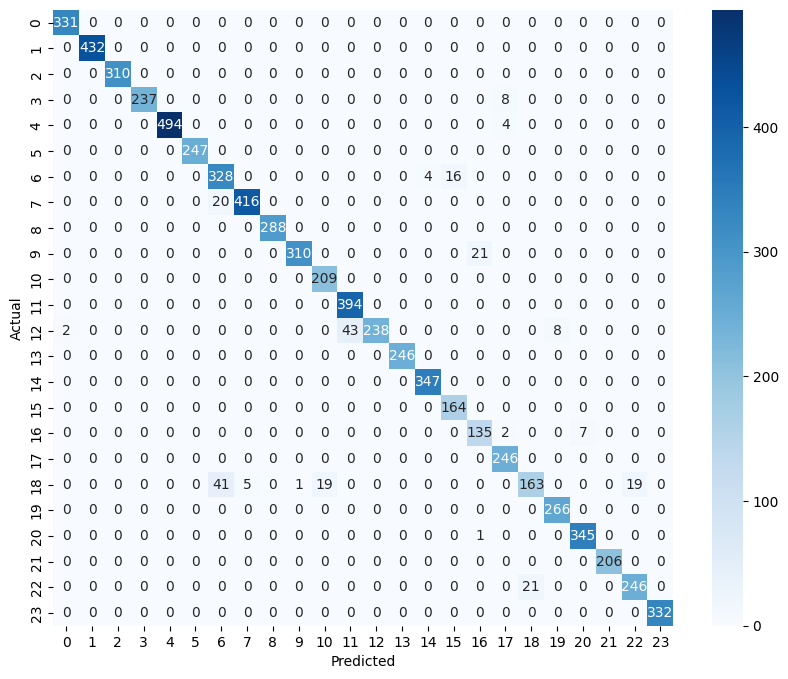

In [13]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [14]:
print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      0.97      0.98       245
           4       1.00      0.99      1.00       498
           5       1.00      1.00      1.00       247
           6       0.84      0.94      0.89       348
           7       0.99      0.95      0.97       436
           8       1.00      1.00      1.00       288
          10       1.00      0.94      0.97       331
          11       0.92      1.00      0.96       209
          12       0.90      1.00      0.95       394
          13       1.00      0.82      0.90       291
          14       1.00      1.00      1.00       246
          15       0.99      1.00      0.99       347
          16       0.91      1.00      0.95       164
          17       0.86      0.94      0.90       144
          18       0.95    

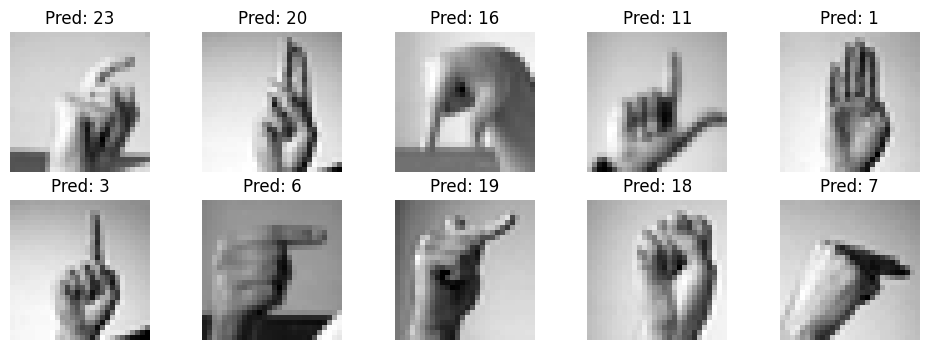

In [15]:
plt.figure(figsize=(12,4))
for i in range(10):
    idx = np.random.randint(0, len(X_test))
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx].reshape(28,28), cmap="gray")
    plt.title(f"Pred: {y_pred_classes[idx]}")
    plt.axis("off")

plt.show()


In [16]:
model.save("../trained_models/sign_mnist_cnn.h5")
print("Model saved.")


Model saved.


Running inference on sample images...



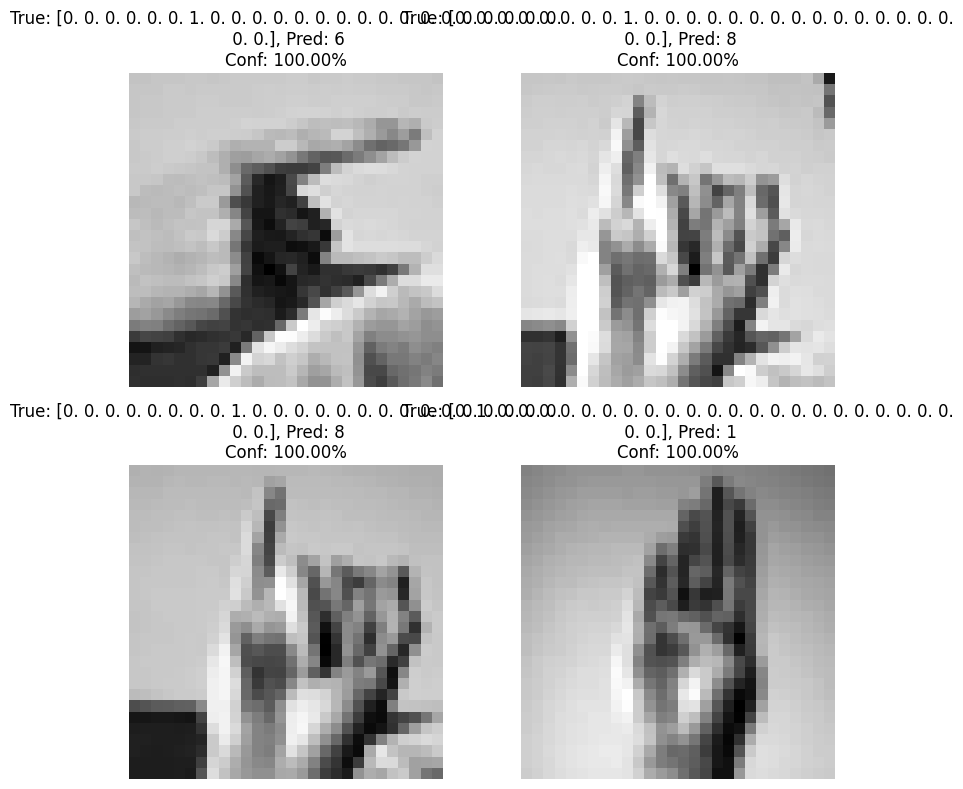

✓ Inference examples saved to models/inference_examples.png


In [17]:
# Cell 17: Single image inference example
import numpy as np
import matplotlib.pyplot as plt

print("Running inference on sample images...\n")

# Select a few test samples
sample_indices = [0, 10, 100, 500]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    # Get sample
    sample_image = X_test[sample_idx:sample_idx+1]
    true_label = y_test[sample_idx]
    
    # Predict
    pred = model.predict(sample_image, verbose=0)
    pred_label = np.argmax(pred[0])
    confidence = np.max(pred[0])
    
    # Plot
    axes[idx].imshow(sample_image[0].squeeze(), cmap='gray')
    axes[idx].set_title(f"True: {true_label}, Pred: {pred_label}\nConf: {confidence:.2%}")
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('models/inference_examples.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Inference examples saved to models/inference_examples.png")

In [ ]:
import cv2
import numpy as np

# label mapping for Sign-MNIST (A–Z except J & Z)
labels_map = {
    0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G',
    7:'H', 8:'I', 9:'J', 10:'K', 11:'L', 12:'M', 13:'N',
    14:'O', 15:'P', 16:'Q', 17:'R', 18:'S', 19:'T',
    20:'U', 21:'V', 22:'W', 23:'X', 24:'Y', 25:'Z'
}

cap = cv2.VideoCapture(0)

print("Real-Time Hand Gesture Recognition Started...")
print("Press 'q' to exit.")

while True:
    ret, frame = cap.read()
    if not ret:
        continue

    # Flip for natural mirror effect
    frame = cv2.flip(frame, 1)

    # ROI box (center)
    h, w, _ = frame.shape
    size = 300
    x1 = w//2 - size//2
    y1 = h//2 - size//2
    x2 = x1 + size
    y2 = y1 + size

    cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)

    roi = frame[y1:y2, x1:x2]
    
    # Preprocess ROI
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (28,28))
    gray = gray.reshape(1,28,28,1) / 255.0

    # Prediction
    preds = model.predict(gray)
    class_idx = np.argmax(preds)
    confidence = preds[0][class_idx] * 100

    predicted_letter = labels_map[class_idx]

    # Display
    cv2.putText(frame, f"{predicted_letter} ({confidence:.2f}%)",
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0,255,0), 2)

    cv2.imshow("SignBridge - Real Time Test", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Real-Time Hand Gesture Recognition Started...
Press 'q' to exit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━